In [28]:
import numpy as np
import os
import sys
import wave
import copy
import math



from sklearn.preprocessing import label_binarize
import os
import csv
import wave
import sys
import numpy as np
import pandas as pd
import glob


def split_wav(wav, emotions):
    (nchannels, sampwidth, framerate, nframes, comptype, compname), samples = wav

    left = samples[0::nchannels]
    right = samples[1::nchannels]

    frames = []
    for ie, e in enumerate(emotions):
        start = e['start']
        end = e['end']

        e['right'] = right[int(start * framerate):int(end * framerate)]
        e['left'] = left[int(start * framerate):int(end * framerate)]

        frames.append({'left': e['left'], 'right': e['right']})
    return frames


def get_field(data, key):
    return np.array([e[key] for e in data])

def pad_sequence_into_array(Xs, maxlen=None, truncating='post', padding='post', value=0.):

    Nsamples = len(Xs)
    if maxlen is None:
        lengths = [s.shape[0] for s in Xs]    # 'sequences' must be list, 's' must be numpy array, len(s) return the first dimension of s
        maxlen = np.max(lengths)

    Xout = np.ones(shape=[Nsamples, maxlen] + list(Xs[0].shape[1:]), dtype=Xs[0].dtype) * np.asarray(value, dtype=Xs[0].dtype)
    Mask = np.zeros(shape=[Nsamples, maxlen], dtype=Xout.dtype)
    for i in range(Nsamples):
        x = Xs[i]
        if truncating == 'pre':
            trunc = x[-maxlen:]
        elif truncating == 'post':
            trunc = x[:maxlen]
        else:
            raise ValueError("Truncating type '%s' not understood" % truncating)
        if padding == 'post':
            Xout[i, :len(trunc)] = trunc
            Mask[i, :len(trunc)] = 1
        elif padding == 'pre':
            Xout[i, -len(trunc):] = trunc
            Mask[i, -len(trunc):] = 1
        else:
            raise ValueError("Padding type '%s' not understood" % padding)
    return Xout, Mask


def convert_gt_from_array_to_list(gt_batch, gt_batch_mask=None):

    B, L = gt_batch.shape
    gt_batch = gt_batch.astype('int')
    gts = []
    for i in range(B):
        if gt_batch_mask is None:
            l = L
        else:
            l = int(gt_batch_mask[i, :].sum())
        gts.append(gt_batch[i, :l].tolist())
    return gts

def get_audio(path_to_wav, filename):
    wav = wave.open(path_to_wav + filename, mode="r")
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()
    content = wav.readframes(nframes)
    samples = np.fromstring(content, dtype=np.int16)
    return (nchannels, sampwidth, framerate, nframes, comptype, compname), samples


def get_transcriptions(path_to_transcriptions, filename):
    f = open(path_to_transcriptions + filename, 'r').read()
    f = np.array(f.split('\n'))
    transcription = {}
    for i in range(len(f) - 1):
        g = f[i]
        i1 = g.find(': ')
        i0 = g.find(' [')
        ind_id = g[:i0]
        ind_ts = g[i1+2:]
        transcription[ind_id] = ind_ts
    return transcription


def get_emotions(path_to_emotions, filename):
    f = open(path_to_emotions + filename, 'r').read()
    f = np.array(f.split('\n'))
    idx = f == ''
    idx_n = np.arange(len(f))[idx]
    emotion = []
    for i in range(len(idx_n) - 2):
        g = f[idx_n[i]+1:idx_n[i+1]]
        head = g[0]
        i0 = head.find(' - ')
        start_time = float(head[head.find('[') + 1:head.find(' - ')])
        end_time = float(head[head.find(' - ') + 3:head.find(']')])
        actor_id = head[head.find(filename[:-4]) + len(filename[:-4]) + 1:
                        head.find(filename[:-4]) + len(filename[:-4]) + 5]
        emo = head[head.find('\t[') - 3:head.find('\t[')]
        vad = head[head.find('\t[') + 1:]

        v = float(vad[1:7])
        a = float(vad[9:15])
        d = float(vad[17:23])
        
        j = 1
        emos = []
        while g[j][0] == "C":
            head = g[j]
            start_idx = head.find("\t") + 1
            evoluator_emo = []
            idx = head.find(";", start_idx)
            while idx != -1:
                evoluator_emo.append(head[start_idx:idx].strip().lower()[:3])
                start_idx = idx + 1
                idx = head.find(";", start_idx)
            emos.append(evoluator_emo)
            j += 1

        emotion.append({'start': start_time,
                        'end': end_time,
                        'id': filename[:-4] + '_' + actor_id,
                        'v': v,
                        'a': a,
                        'd': d,
                        'emotion': emo,
                        'emo_evo': emos})
    return emotion

In [29]:
import sys
import time
import os
import glob
import numpy
import math
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
from scipy.signal import lfilter
from scipy.signal.windows import  hamming


eps = 0.00000001


""" Time-domain audio features """


def stZCR(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    countZ = numpy.sum(numpy.abs(numpy.diff(numpy.sign(frame)))) / 2
    return (numpy.float64(countZ) / numpy.float64(count-1.0))


def stEnergy(frame):
    """Computes signal energy of frame"""
    return numpy.sum(frame ** 2) / numpy.float64(len(frame))


def stEnergyEntropy(frame, numOfShortBlocks=10):
    """Computes entropy of energy"""
    Eol = numpy.sum(frame ** 2)    # total frame energy
    L = len(frame)
    subWinLength = int(numpy.floor(L / numOfShortBlocks))
    if L != subWinLength * numOfShortBlocks:
            frame = frame[0:subWinLength * numOfShortBlocks]
    # subWindows is of size [numOfShortBlocks x L]
    subWindows = frame.reshape(subWinLength, numOfShortBlocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = numpy.sum(subWindows ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -numpy.sum(s * numpy.log2(s + eps))
    return Entropy


""" Frequency-domain audio features """


def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (numpy.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = numpy.sum(ind * Xt)
    DEN = numpy.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = numpy.sqrt(numpy.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)


def stSpectralEntropy(X, numOfShortBlocks=10):
    """Computes the spectral entropy"""
    L = len(X)                         # number of frame samples
    Eol = numpy.sum(X ** 2)            # total spectral energy

    subWinLength = int(numpy.floor(L / numOfShortBlocks))   # length of sub-frame
    if L != subWinLength * numOfShortBlocks:
        X = X[0:subWinLength * numOfShortBlocks]

    subWindows = X.reshape(subWinLength, numOfShortBlocks, order='F').copy()  # define sub-frames (using matrix reshape)
    s = numpy.sum(subWindows ** 2, axis=0) / (Eol + eps)                      # compute spectral sub-energies
    En = -numpy.sum(s*numpy.log2(s + eps))                                    # compute spectral entropy

    return En


def stSpectralFlux(X, Xprev):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        X:        the abs(fft) of the current frame
        Xpre:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    sumX = numpy.sum(X + eps)
    sumPrevX = numpy.sum(Xprev + eps)
    F = numpy.sum((X / sumX - Xprev/sumPrevX) ** 2)

    return F


def stSpectralRollOff(X, c, fs):
    """Computes spectral roll-off"""
    totalEnergy = numpy.sum(X ** 2)
    fftLength = len(X)
    Thres = c*totalEnergy
    # Ffind the spectral rolloff as the frequency position where the respective spectral energy is equal to c*totalEnergy
    CumSum = numpy.cumsum(X ** 2) + eps
    [a, ] = numpy.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = numpy.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return (mC)


def stHarmonic(frame, fs):
    """
    Computes harmonic ratio and pitch
    """
    M = numpy.round(0.016 * fs) - 1
    R = numpy.correlate(frame, frame, mode='full')

    g = R[len(frame)-1]
    R = R[len(frame):-1]

    # estimate m0 (as the first zero crossing of R)
    [a, ] = numpy.nonzero(numpy.diff(numpy.sign(R)))

    if len(a) == 0:
        m0 = len(R)-1
    else:
        m0 = a[0]
    if M > len(R):
        M = len(R) - 1

    Gamma = numpy.zeros((M), dtype=numpy.float64)
    CSum = numpy.cumsum(frame ** 2)
    Gamma[m0:M] = R[m0:M] / (numpy.sqrt((g * CSum[M:m0:-1])) + eps)

    ZCR = stZCR(Gamma)

    if ZCR > 0.15:
        HR = 0.0
        f0 = 0.0
    else:
        if len(Gamma) == 0:
            HR = 1.0
            blag = 0.0
            Gamma = numpy.zeros((M), dtype=numpy.float64)
        else:
            HR = numpy.max(Gamma)
            blag = numpy.argmax(Gamma)

        # Get fundamental frequency:
        f0 = fs / (blag + eps)
        if f0 > 5000:
            f0 = 0.0
        if HR < 0.1:
            f0 = 0.0

    return (HR, f0)


def mfccInitFilterBanks(fs, nfft):
    """
    Computes the triangular filterbank for MFCC computation (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    # filter bank params:
    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    numLinFiltTotal = 13
    numLogFilt = 27

    if fs < 8000:
        nlogfil = 5

    # Total number of filters
    nFiltTotal = numLinFiltTotal + numLogFilt
    #print (str(nFiltTotal))
    #print (str(nfft))

    # Compute frequency points of the triangle:
    freqs = numpy.zeros(nFiltTotal+2)
    freqs[:numLinFiltTotal] = lowfreq + numpy.arange(numLinFiltTotal) * linsc
    freqs[numLinFiltTotal:] = freqs[numLinFiltTotal-1] * logsc ** numpy.arange(1, numLogFilt + 3)
    heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    
    
    fbank = numpy.zeros((int(nFiltTotal), int(nfft)))
    nfreqs = numpy.arange(nfft) / (1. * nfft) * fs

    for i in range(nFiltTotal):
        lowTrFreq = freqs[i]
        cenTrFreq = freqs[i+1]
        highTrFreq = freqs[i+2]

        lid = numpy.arange(numpy.floor(lowTrFreq * nfft / fs) + 1, numpy.floor(cenTrFreq * nfft / fs) + 1, dtype=int)
        lslope = heights[i] / (cenTrFreq - lowTrFreq)
        rid = numpy.arange(numpy.floor(cenTrFreq * nfft / fs) + 1, numpy.floor(highTrFreq * nfft / fs) + 1, dtype=int)
        rslope = heights[i] / (highTrFreq - cenTrFreq)
        fbank[i][lid] = lslope * (nfreqs[lid] - lowTrFreq)
        fbank[i][rid] = rslope * (highTrFreq - nfreqs[rid])

    return fbank, freqs


def stMFCC(X, fbank, nceps):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        X:        fft magnitude abs(FFT)
        fbank:    filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:     MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = numpy.log10(numpy.dot(X, fbank.T)+eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:nceps]
    return ceps


def stChromaFeaturesInit(nfft, fs):
    """
    This function initializes the chroma matrices used in the calculation of the chroma features
    """
    freqs = numpy.array([((f + 1) * fs) / (2 * int(nfft)) for f in range(int(nfft))])
    Cp = 27.50

    nChroma = numpy.round(12.0 * numpy.log2(freqs / Cp)).astype(int)

    nFreqsPerChroma = numpy.zeros((nChroma.shape[0], ))

    uChroma = numpy.unique(nChroma)
    for u in uChroma:
        idx = numpy.nonzero(nChroma == u)
        nFreqsPerChroma[idx] = idx[0].shape
    return nChroma, nFreqsPerChroma


def stChromaFeatures(X, fs, nChroma, nFreqsPerChroma):
    #TODO: 1 complexity
    #TODO: 2 bug with large windows

    chromaNames = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = X**2
    C = numpy.zeros((nChroma.shape[0],))
    C[nChroma] = spec
    C /= nFreqsPerChroma[nChroma]
    finalC = numpy.zeros((12, 1))
    newD = int(numpy.ceil(C.shape[0] // 12.0) * 12)
    C2 = numpy.zeros((newD, ))
    #C2[0:C.shape[0]] = C
    C2 = C2.reshape(int(numpy.ceil(C2.shape[0]//12)), 12)
    #for i in range(12):
    #    finalC[i] = numpy.sum(C[i:C.shape[0]:12])
    finalC = numpy.matrix(numpy.sum(C2, axis=0)).T
    finalC /= spec.sum()

#    ax = plt.gca()
#    plt.hold(False)
#    plt.plot(finalC)
#    ax.set_xticks(range(len(chromaNames)))
#    ax.set_xticklabels(chromaNames)
#    xaxis = numpy.arange(0, 0.02, 0.01);
#    ax.set_yticks(range(len(xaxis)))
#    ax.set_yticklabels(xaxis)
#    plt.show(block=False)
#    plt.draw()

    return chromaNames, finalC


def stChromagram(signal, Fs, Win, Step, PLOT=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a numpy array (nFFT x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        Fs:          the sampling freq (in Hz)
        Win:         the short-term window size (in samples)
        Step:        the short-term window step (in samples)
        PLOT:        flag, 1 if results are to be ploted
    RETURNS:
    """
    Win = int(Win)
    Step = int(Step)
    signal = numpy.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX - DC)

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0
    nfft = int(Win / 2)
    nChroma, nFreqsPerChroma = stChromaFeaturesInit(nfft, Fs)
    chromaGram = numpy.array([], dtype=numpy.float64)

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos + Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)
        chromaNames, C = stChromaFeatures(X, Fs, nChroma, nFreqsPerChroma)
        C = C[:, 0]
        if countFrames == 1:
            chromaGram = C.T
        else:
            chromaGram = numpy.vstack((chromaGram, C.T))
    FreqAxis = chromaNames
    TimeAxis = [(t * Step) / Fs for t in range(chromaGram.shape[0])]

    if (PLOT):
        fig, ax = plt.subplots()
        chromaGramToPlot = chromaGram.transpose()[::-1, :]
        Ratio = chromaGramToPlot.shape[1] / (3*chromaGramToPlot.shape[0])
        chromaGramToPlot = numpy.repeat(chromaGramToPlot, Ratio, axis=0)
        imgplot = plt.imshow(chromaGramToPlot)
        Fstep = int(nfft / 5.0)
#        FreqTicks = range(0, int(nfft) + Fstep, Fstep)
#        FreqTicksLabels = [str(Fs/2-int((f*Fs) / (2*nfft))) for f in FreqTicks]
        ax.set_yticks(range(Ratio / 2, len(FreqAxis) * Ratio, Ratio))
        ax.set_yticklabels(FreqAxis[::-1])
        TStep = countFrames / 3
        TimeTicks = range(0, countFrames, TStep)
        TimeTicksLabels = ['%.2f' % (float(t * Step) / Fs) for t in TimeTicks]
        ax.set_xticks(TimeTicks)
        ax.set_xticklabels(TimeTicksLabels)
        ax.set_xlabel('time (secs)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return (chromaGram, TimeAxis, FreqAxis)


def phormants(x, Fs):
    N = len(x)
    w = numpy.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w   
    x1 = lfilter([1], [1., 0.63], x1)
    
    # Get LPC.    
    ncoeff = 2 + Fs / 1000
    A, e, k = lpc(x1, ncoeff)    
    #A, e, k = lpc(x1, 8)

    # Get roots.
    rts = numpy.roots(A)
    rts = [r for r in rts if numpy.imag(r) >= 0]

    # Get angles.
    angz = numpy.arctan2(numpy.imag(rts), numpy.real(rts))

    # Get frequencies.    
    frqs = sorted(angz * (Fs / (2 * math.pi)))

    return frqs
def beatExtraction(stFeatures, winSize, PLOT=False):
    """
    This function extracts an estimate of the beat rate for a musical signal.
    ARGUMENTS:
     - stFeatures:     a numpy array (numOfFeatures x numOfShortTermWindows)
     - winSize:        window size in seconds
    RETURNS:
     - BPM:            estimates of beats per minute
     - Ratio:          a confidence measure
    """

    # Features that are related to the beat tracking task:
    toWatch = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

    maxBeatTime = int(round(2.0 / winSize))
    HistAll = numpy.zeros((maxBeatTime,))
    for ii, i in enumerate(toWatch):                                        # for each feature
        DifThres = 2.0 * (numpy.abs(stFeatures[i, 0:-1] - stFeatures[i, 1::])).mean()    # dif threshold (3 x Mean of Difs)
        [pos1, _] = utilities.peakdet(stFeatures[i, :], DifThres)           # detect local maxima
        posDifs = []                                                        # compute histograms of local maxima changes
        for j in range(len(pos1)-1):
            posDifs.append(pos1[j+1]-pos1[j])
        [HistTimes, HistEdges] = numpy.histogram(posDifs, numpy.arange(0.5, maxBeatTime + 1.5))
        HistCenters = (HistEdges[0:-1] + HistEdges[1::]) / 2.0
        HistTimes = HistTimes.astype(float) / stFeatures.shape[1]
        HistAll += HistTimes
        if PLOT:
            plt.subplot(9, 2, ii + 1)
            plt.plot(stFeatures[i, :], 'k')
            for k in pos1:
                plt.plot(k, stFeatures[i, k], 'k*')
            f1 = plt.gca()
            f1.axes.get_xaxis().set_ticks([])
            f1.axes.get_yaxis().set_ticks([])

    if PLOT:
        plt.show(block=False)
        plt.figure()

    # Get beat as the argmax of the agregated histogram:
    I = numpy.argmax(HistAll)
    BPMs = 60 / (HistCenters * winSize)
    BPM = BPMs[I]
    # ... and the beat ratio:
    Ratio = HistAll[I] / HistAll.sum()

    if PLOT:
        # filter out >500 beats from plotting:
        HistAll = HistAll[BPMs < 500]
        BPMs = BPMs[BPMs < 500]

        plt.plot(BPMs, HistAll, 'k')
        plt.xlabel('Beats per minute')
        plt.ylabel('Freq Count')
        plt.show(block=True)

    return BPM, Ratio


def stSpectogram(signal, Fs, Win, Step, PLOT=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a numpy array (nFFT x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        Fs:          the sampling freq (in Hz)
        Win:         the short-term window size (in samples)
        Step:        the short-term window step (in samples)
        PLOT:        flag, 1 if results are to be ploted
    RETURNS:
    """
    Win = int(Win)
    Step = int(Step)
    signal = numpy.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX - DC)

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0
    nfft = int(Win / 2)
    specgram = numpy.array([], dtype=numpy.float64)

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos+Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)

        if countFrames == 1:
            specgram = X ** 2
        else:
            specgram = numpy.vstack((specgram, X))

    FreqAxis = [((f + 1) * Fs) / (2 * nfft) for f in range(specgram.shape[1])]
    TimeAxis = [(t * Step) / Fs for t in range(specgram.shape[0])]

    if (PLOT):
        fig, ax = plt.subplots()
        imgplot = plt.imshow(specgram.transpose()[::-1, :])
        Fstep = int(nfft / 5.0)
        FreqTicks = range(0, int(nfft) + Fstep, Fstep)
        FreqTicksLabels = [str(Fs / 2 - int((f * Fs) / (2 * nfft))) for f in FreqTicks]
        ax.set_yticks(FreqTicks)
        ax.set_yticklabels(FreqTicksLabels)
        TStep = countFrames/3
        TimeTicks = range(0, countFrames, TStep)
        TimeTicksLabels = ['%.2f' % (float(t * Step) / Fs) for t in TimeTicks]
        ax.set_xticks(TimeTicks)
        ax.set_xticklabels(TimeTicksLabels)
        ax.set_xlabel('time (secs)')
        ax.set_ylabel('freq (Hz)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return (specgram, TimeAxis, FreqAxis)


""" Windowing and feature extraction """


def stFeatureExtraction(signal, Fs, Win, Step):
    """
    This function implements the shor-term windowing process. For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a numpy matrix.
    ARGUMENTS
        signal:       the input signal samples
        Fs:           the sampling freq (in Hz)
        Win:          the short-term window size (in samples)
        Step:         the short-term window step (in samples)
    RETURNS
        stFeatures:   a numpy array (numOfFeatures x numOfShortTermWindows)
    """

    Win = int(Win)
    Step = int(Step)

    # Signal normalization
    signal = numpy.double(signal)

    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / MAX

    N = len(signal)                                # total number of samples
    curPos = 0
    countFrames = 0
    nFFT = Win / 2

    [fbank, freqs] = mfccInitFilterBanks(Fs, nFFT)                # compute the triangular filter banks used in the mfcc calculation
    nChroma, nFreqsPerChroma = stChromaFeaturesInit(nFFT, Fs)


    numOfPitches = 5
    numOfPeaks = 10
    numOfTimeSpectralFeatures = 8
    numOfHarmonicFeatures = 0
    nceps = 13
    numOfChromaFeatures = 13

    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures + numOfChromaFeatures
#    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures
    stFeatures = numpy.array([], dtype=numpy.float64)

    while (curPos + Win - 1 < N):                        # for each short-term window until the end of signal
        countFrames += 1
        x = signal[curPos:curPos+Win]                    # get current window
        curPos = curPos + Step                           # update window position
        X = abs(fft(x))                                  # get fft magnitude
        X = X[0:int(nFFT)]                                    # normalize fft
        X = X / len(X)
        if countFrames == 1:
            Xprev = X.copy()                             # keep previous fft mag (used in spectral flux)
        curFV = numpy.zeros((totalNumOfFeatures, 1))
        curFV[0] = stZCR(x)                              # zero crossing rate
        curFV[1] = stEnergy(x)                           # short-term energy
        curFV[2] = stEnergyEntropy(x)                    # short-term entropy of energy
        [curFV[3], curFV[4]] = stSpectralCentroidAndSpread(X, Fs)    # spectral centroid and spread
        curFV[5] = stSpectralEntropy(X)                  # spectral entropy
        curFV[6] = stSpectralFlux(X, Xprev)              # spectral flux
        curFV[7] = stSpectralRollOff(X, 0.90, Fs)        # spectral rolloff
        curFV[numOfTimeSpectralFeatures:numOfTimeSpectralFeatures+nceps, 0] = stMFCC(X, fbank, nceps).copy()    # MFCCs

        chromaNames, chromaF = stChromaFeatures(X, Fs, nChroma, nFreqsPerChroma)
        curFV[numOfTimeSpectralFeatures + nceps: numOfTimeSpectralFeatures + nceps + numOfChromaFeatures - 1] = chromaF
        numOfCFFeatures = numOfTimeSpectralFeatures + nceps + numOfChromaFeatures

        curFV[numOfCFFeatures-1] = chromaF.std()
        
        if countFrames == 1:
            stFeatures = curFV                                        # initialize feature matrix (if first frame)
        else:
            stFeatures = numpy.concatenate((stFeatures, curFV), 1)    # update feature matrix
        Xprev = X.copy()

    return numpy.array(stFeatures)


def mtFeatureExtraction(signal, Fs, mtWin, mtStep, stWin, stStep):
    """
    Mid-term feature extraction
    """

    mtWinRatio = int(round(mtWin / stStep))
    mtStepRatio = int(round(mtStep / stStep))

    mtFeatures = []

    stFeatures = stFeatureExtraction(signal, Fs, stWin, stStep)
    numOfFeatures = len(stFeatures)
    numOfStatistics = 2

    mtFeatures = []
    #for i in range(numOfStatistics * numOfFeatures + 1):
    for i in range(numOfStatistics * numOfFeatures):
        mtFeatures.append([])

    for i in range(numOfFeatures):        # for each of the short-term features:
        curPos = 0
        N = len(stFeatures[i])
        while (curPos < N):
            N1 = curPos
            N2 = curPos + mtWinRatio
            if N2 > N:
                N2 = N
            curStFeatures = stFeatures[i][N1:N2]

            mtFeatures[i].append(numpy.mean(curStFeatures))
            mtFeatures[i+numOfFeatures].append(numpy.std(curStFeatures))
            #mtFeatures[i+2*numOfFeatures].append(numpy.std(curStFeatures) / (numpy.mean(curStFeatures)+0.00000010))
            curPos += mtStepRatio

    return numpy.array(mtFeatures), stFeatures


# TODO
def stFeatureSpeed(signal, Fs, Win, Step):

    signal = numpy.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / MAX
    # print (numpy.abs(signal)).max()

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0

    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    nlinfil = 13
    nlogfil = 27
    nceps = 13
    nfil = nlinfil + nlogfil
    nfft = Win / 2
    if Fs < 8000:
        nlogfil = 5
        nfil = nlinfil + nlogfil
        nfft = Win / 2

    # compute filter banks for mfcc:
    [fbank, freqs] = mfccInitFilterBanks(Fs, nfft, lowfreq, linsc, logsc, nlinfil, nlogfil)

    numOfTimeSpectralFeatures = 8
    numOfHarmonicFeatures = 1
    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures
    #stFeatures = numpy.array([], dtype=numpy.float64)
    stFeatures = []

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos + Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)
        Ex = 0.0
        El = 0.0
        X[0:4] = 0
#        M = numpy.round(0.016 * fs) - 1
#        R = numpy.correlate(frame, frame, mode='full')
        stFeatures.append(stHarmonic(x, Fs))
#        for i in range(len(X)):
            #if (i < (len(X) / 8)) and (i > (len(X)/40)):
            #    Ex += X[i]*X[i]
            #El += X[i]*X[i]
#        stFeatures.append(Ex / El)
#        stFeatures.append(numpy.argmax(X))
#        if curFV[numOfTimeSpectralFeatures+nceps+1]>0:
#            print curFV[numOfTimeSpectralFeatures+nceps], curFV[numOfTimeSpectralFeatures+nceps+1]
    return numpy.array(stFeatures)


""" Feature Extraction Wrappers
 - The first two feature extraction wrappers are used to extract long-term averaged
   audio features for a list of WAV files stored in a given category.
   It is important to note that, one single feature is extracted per WAV file (not the whole sequence of feature vectors)
 """


def dirWavFeatureExtraction(dirName, mtWin, mtStep, stWin, stStep, computeBEAT=False):
    """
    This function extracts the mid-term features of the WAVE files of a particular folder.
    The resulting feature vector is extracted by long-term averaging the mid-term features.
    Therefore ONE FEATURE VECTOR is extracted for each WAV file.
    ARGUMENTS:
        - dirName:        the path of the WAVE directory
        - mtWin, mtStep:    mid-term window and step (in seconds)
        - stWin, stStep:    short-term window and step (in seconds)
    """

    allMtFeatures = numpy.array([])
    processingTimes = []

    types = ('*.wav', '*.aif',  '*.aiff')
    wavFilesList = []
    for files in types:
        wavFilesList.extend(glob.glob(os.path.join(dirName, files)))

    wavFilesList = sorted(wavFilesList)

    for wavFile in wavFilesList:
        [Fs, x] = audioBasicIO.readAudioFile(wavFile)            # read file
        t1 = time.clock()
        x = audioBasicIO.stereo2mono(x)                          # convert stereo to mono
        if computeBEAT:                                          # mid-term feature extraction for current file
            [MidTermFeatures, stFeatures] = mtFeatureExtraction(x, Fs, round(mtWin * Fs), round(mtStep * Fs), round(Fs * stWin), round(Fs * stStep))
            [beat, beatConf] = beatExtraction(stFeatures, stStep)
        else:
            [MidTermFeatures, _] = mtFeatureExtraction(x, Fs, round(mtWin * Fs), round(mtStep * Fs), round(Fs * stWin), round(Fs * stStep))

        MidTermFeatures = numpy.transpose(MidTermFeatures)
        MidTermFeatures = MidTermFeatures.mean(axis=0)         # long term averaging of mid-term statistics
        if computeBEAT:
            MidTermFeatures = numpy.append(MidTermFeatures, beat)
            MidTermFeatures = numpy.append(MidTermFeatures, beatConf)
        if len(allMtFeatures) == 0:                              # append feature vector
            allMtFeatures = MidTermFeatures
        else:
            allMtFeatures = numpy.vstack((allMtFeatures, MidTermFeatures))
        t2 = time.clock()
        duration = float(len(x)) / Fs
        processingTimes.append((t2 - t1) / duration)
    if len(processingTimes) > 0:
        print("Feature extraction complexity ratio: {0:.1f} x realtime".format((1.0 / numpy.mean(numpy.array(processingTimes)))))
    return (allMtFeatures, wavFilesList)


def dirsWavFeatureExtraction(dirNames, mtWin, mtStep, stWin, stStep, computeBEAT=False):
    '''
    Same as dirWavFeatureExtraction, but instead of a single dir it takes a list of paths as input and returns a list of feature matrices.
    EXAMPLE:
    [features, classNames] =
           a.dirsWavFeatureExtraction(['audioData/classSegmentsRec/noise','audioData/classSegmentsRec/speech',
                                       'audioData/classSegmentsRec/brush-teeth','audioData/classSegmentsRec/shower'], 1, 1, 0.02, 0.02);
    It can be used during the training process of a classification model ,
    in order to get feature matrices from various audio classes (each stored in a seperate path)
    '''

    # feature extraction for each class:
    features = []
    classNames = []
    fileNames = []
    for i, d in enumerate(dirNames):
        [f, fn] = dirWavFeatureExtraction(d, mtWin, mtStep, stWin, stStep, computeBEAT=computeBEAT)
        if f.shape[0] > 0:       # if at least one audio file has been found in the provided folder:
            features.append(f)
            fileNames.append(fn)
            if d[-1] == "/":
                classNames.append(d.split(os.sep)[-2])
            else:
                classNames.append(d.split(os.sep)[-1])
    return features, classNames, fileNames


def dirWavFeatureExtractionNoAveraging(dirName, mtWin, mtStep, stWin, stStep):
    """
    This function extracts the mid-term features of the WAVE files of a particular folder without averaging each file.
    ARGUMENTS:
        - dirName:          the path of the WAVE directory
        - mtWin, mtStep:    mid-term window and step (in seconds)
        - stWin, stStep:    short-term window and step (in seconds)
    RETURNS:
        - X:                A feature matrix
        - Y:                A matrix of file labels
        - filenames:
    """

    allMtFeatures = numpy.array([])
    signalIndices = numpy.array([])
    processingTimes = []

    types = ('*.wav', '*.aif',  '*.aiff')
    wavFilesList = []
    for files in types:
        wavFilesList.extend(glob.glob(os.path.join(dirName, files)))

    wavFilesList = sorted(wavFilesList)

    for i, wavFile in enumerate(wavFilesList):
        [Fs, x] = audioBasicIO.readAudioFile(wavFile)            # read file
        x = audioBasicIO.stereo2mono(x)                          # convert stereo to mono
        [MidTermFeatures, _] = mtFeatureExtraction(x, Fs, round(mtWin * Fs), round(mtStep * Fs), round(Fs * stWin), round(Fs * stStep))  # mid-term feature

        MidTermFeatures = numpy.transpose(MidTermFeatures)
#        MidTermFeatures = MidTermFeatures.mean(axis=0)        # long term averaging of mid-term statistics
        if len(allMtFeatures) == 0:                # append feature vector
            allMtFeatures = MidTermFeatures
            signalIndices = numpy.zeros((MidTermFeatures.shape[0], ))
        else:
            allMtFeatures = numpy.vstack((allMtFeatures, MidTermFeatures))
            signalIndices = numpy.append(signalIndices, i * numpy.ones((MidTermFeatures.shape[0], )))

    return (allMtFeatures, signalIndices, wavFilesList)


# The following two feature extraction wrappers extract features for given audio files, however
# NO LONG-TERM AVERAGING is performed. Therefore, the output for each audio file is NOT A SINGLE FEATURE VECTOR
# but a whole feature matrix.
#
# Also, another difference between the following two wrappers and the previous is that they NO LONG-TERM AVERAGING IS PERFORMED.
# In other words, the WAV files in these functions are not used as uniform samples that need to be averaged but as sequences

def mtFeatureExtractionToFile(fileName, midTermSize, midTermStep, shortTermSize, shortTermStep, outPutFile,
                              storeStFeatures=False, storeToCSV=False, PLOT=False):
    """
    This function is used as a wrapper to:
    a) read the content of a WAV file
    b) perform mid-term feature extraction on that signal
    c) write the mid-term feature sequences to a numpy file
    """
    [Fs, x] = audioBasicIO.readAudioFile(fileName)            # read the wav file
    x = audioBasicIO.stereo2mono(x)                           # convert to MONO if required
    if storeStFeatures:
        [mtF, stF] = mtFeatureExtraction(x, Fs, round(Fs * midTermSize), round(Fs * midTermStep), round(Fs * shortTermSize), round(Fs * shortTermStep))
    else:
        [mtF, _] = mtFeatureExtraction(x, Fs, round(Fs*midTermSize), round(Fs * midTermStep), round(Fs * shortTermSize), round(Fs * shortTermStep))

    numpy.save(outPutFile, mtF)                              # save mt features to numpy file
    if PLOT:
        print("Mid-term numpy file: " + outPutFile + ".npy saved")
    if storeToCSV:
        numpy.savetxt(outPutFile+".csv", mtF.T, delimiter=",")
        if PLOT:
            print("Mid-term CSV file: " + outPutFile + ".csv saved")

    if storeStFeatures:
        numpy.save(outPutFile+"_st", stF)                    # save st features to numpy file
        if PLOT:
            print("Short-term numpy file: " + outPutFile + "_st.npy saved")
        if storeToCSV:
            numpy.savetxt(outPutFile+"_st.csv", stF.T, delimiter=",")    # store st features to CSV file
            if PLOT:
                print("Short-term CSV file: " + outPutFile + "_st.csv saved")


def mtFeatureExtractionToFileDir(dirName, midTermSize, midTermStep, shortTermSize, shortTermStep, storeStFeatures=False, storeToCSV=False, PLOT=False):
    types = (dirName + os.sep + '*.wav', )
    filesToProcess = []
    for files in types:
        filesToProcess.extend(glob.glob(files))
    for f in filesToProcess:
        outPath = f
        mtFeatureExtractionToFile(f, midTermSize, midTermStep, shortTermSize, shortTermStep, outPath, storeStFeatures, storeToCSV, PLOT)


/tmp/ipykernel_31/3114072718.py:8: DeprecationWarning: Please import `dct` from the `scipy.fftpack` namespace; the `scipy.fftpack.realtransforms` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.fftpack.realtransforms import dct


#### 

In [30]:
code_path = os.path.dirname(os.path.realpath(os.getcwd()))
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = "../../../data/sessions/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [ ]:
import pickle
with open('/input/sdfdasfsa/data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [32]:
def calculate_features(frames, freq, options):
    window_sec = 0.2
    window_n = int(freq * window_sec)

    st_f = stFeatureExtraction(frames, freq, window_n, window_n / 2)

    if st_f.shape[1] > 2:
        i0 = 1
        i1 = st_f.shape[1] - 1
        if i1 - i0 < 1:
            i1 = i0 + 1
        
        deriv_st_f = np.zeros((st_f.shape[0], i1 - i0), dtype=float)
        for i in range(i0, i1):
            i_left = i - 1
            i_right = i + 1
            deriv_st_f[:st_f.shape[0], i - i0] = st_f[:, i]
        return deriv_st_f
    elif st_f.shape[1] == 2:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f
    else:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f

In [33]:
x_train_speech = []

counter = 0
for ses_mod in data2:
    x_head = ses_mod['signal']
    st_features = calculate_features(x_head, framerate, None)
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    x_train_speech.append( st_features.T )
    counter+=1
    if(counter%100==0):
        print(counter)
    
x_train_speech = np.array(x_train_speech)
x_train_speech.shape

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


(4936, 100, 34)

In [34]:
x_train_mocap = []
counter = 0
for ses_mod in data2:
    x_head = ses_mod['mocap_head']
    if(x_head.shape != (200,18)):
        x_head = np.zeros((200,18))   
    x_head[np.isnan(x_head)]=0
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,6)):
        x_hand = np.zeros((200,6))   
    x_hand[np.isnan(x_hand)]=0
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))   
    x_rot[np.isnan(x_rot)]=0
    x_mocap = np.concatenate((x_head, x_hand), axis=1)
    x_mocap = np.concatenate((x_mocap, x_rot), axis=1)
    x_train_mocap.append(x_mocap)
    
x_train_mocap = np.array(x_train_mocap)
x_train_mocap = x_train_mocap.reshape(-1,200,189,1)
x_train_mocap.shape

(4936, 200, 189, 1)

In [35]:
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])


In [37]:
Y = label_binarize(Y,classes=emotions_used)

Y.shape

(4936, 4)

In [38]:
from torch.utils.data import TensorDataset, random_split
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_speech = torch.tensor(x_train_speech, dtype=torch.float32).to(device)
x_train_mocap = torch.tensor(x_train_mocap, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_labels = torch.tensor(Y, dtype=torch.long).to(device)

dataset = TensorDataset(x_train_speech, x_train_mocap, y_train_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
dataset[0][0].shape

torch.Size([100, 34])

In [40]:
dataset[0][1].shape

torch.Size([1, 200, 189])

In [41]:
dataset[0][2].shape 

torch.Size([4])

## Baseline

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SpeechModel(nn.Module):
    def __init__(self):
        super(SpeechModel, self).__init__()
        self.lstm = nn.LSTM(input_size=34, hidden_size=128, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 100, 256)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class MoCapModel(nn.Module):
    def __init__(self):
        super(MoCapModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 6, 256)

    def forward(self, x):
        x = F.relu(self.dropout(self.conv1(x)))
        x = F.relu(self.dropout(self.conv2(x)))
        x = F.relu(self.dropout(self.conv3(x)))
        x = F.relu(self.dropout(self.conv4(x)))
        x = F.relu(self.dropout(self.conv5(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.speech_model = SpeechModel()
        self.mocap_model = MoCapModel()
        self.fc1 = nn.Linear(256 + 256, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 classes for output

    def forward(self, x_speech, x_mocap):
        out_speech = self.speech_model(x_speech)
        out_mocap = self.mocap_model(x_mocap)
        combined = torch.cat((out_speech, out_mocap), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)  # Logits output (no softmax)
        return x

model = CombinedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for speech, mocap, labels in train_loader:
        speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
        
        labels = torch.argmax(labels, dim=1) 

        optimizer.zero_grad()
        outputs = model(speech, mocap)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for speech, mocap, labels in test_loader:
            speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)

            outputs = model(speech, mocap)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")

[Epoch 1/10] Train Loss: 1.3567, Train Accuracy: 35.66%
Test Accuracy: 36.34%
[Epoch 2/10] Train Loss: 1.3411, Train Accuracy: 37.01%
Test Accuracy: 35.83%
[Epoch 3/10] Train Loss: 1.3270, Train Accuracy: 38.15%
Test Accuracy: 36.23%
[Epoch 4/10] Train Loss: 1.2946, Train Accuracy: 40.37%
Test Accuracy: 39.27%
[Epoch 5/10] Train Loss: 1.2427, Train Accuracy: 42.02%
Test Accuracy: 42.41%
[Epoch 6/10] Train Loss: 1.2024, Train Accuracy: 44.38%
Test Accuracy: 45.65%
[Epoch 7/10] Train Loss: 1.1775, Train Accuracy: 45.26%
Test Accuracy: 44.64%
[Epoch 8/10] Train Loss: 1.1650, Train Accuracy: 46.23%
Test Accuracy: 44.84%
[Epoch 9/10] Train Loss: 1.1548, Train Accuracy: 47.01%
Test Accuracy: 46.96%
[Epoch 10/10] Train Loss: 1.1445, Train Accuracy: 46.99%
Test Accuracy: 45.85%


In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 类别标签
class_names = ['ang', 'exc', 'neu', 'sad']

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for speech, mocap, labels in test_loader:
            speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)

            outputs = model(speech, mocap)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 打印分类报告
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)

    # 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return cm

Classification Report:

              precision    recall  f1-score   support

         ang     0.4859    0.5307    0.5073       228
         exc     0.3590    0.0711    0.1186       197
         neu     0.4289    0.5412    0.4785       340
         sad     0.4945    0.6009    0.5425       223

    accuracy                         0.4585       988
   macro avg     0.4421    0.4360    0.4118       988
weighted avg     0.4429    0.4585    0.4279       988



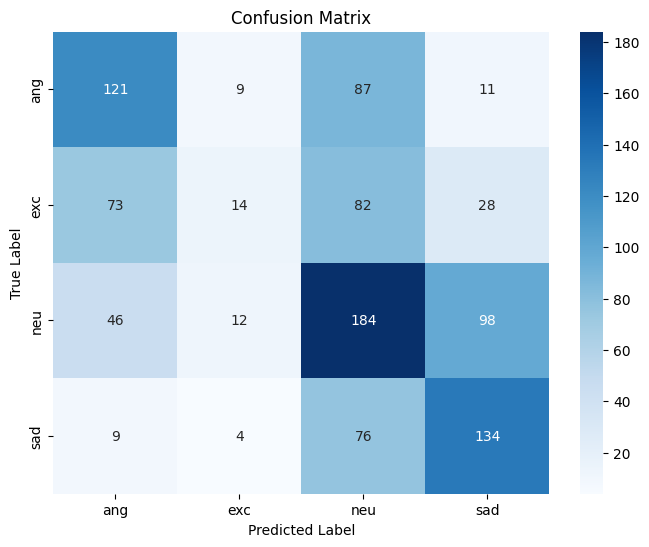

In [49]:
cm = evaluate_model(model, test_loader, device)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from torch.utils.data import DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn.functional as F
from transformers import Wav2Vec2Model

class SpeechModel(nn.Module):
    def __init__(self):
        super(SpeechModel, self).__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        self.fc = nn.Linear(768, 128)

    def forward(self, x):  # x: [batch, 100, 34]
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # [batch, 100 * 34]
        x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-6)
        x = F.interpolate(x.unsqueeze(1), size=16000, mode='linear').squeeze(1)  # [batch, 16000]
        features = self.wav2vec2(x).last_hidden_state  # [batch, seq_len, 768]
        pooled = features.mean(dim=1)  # [batch, 768]
        x = self.fc(pooled)  # [batch, 128]
        return x

class MoCapModel(nn.Module):
    def __init__(self):
        super(MoCapModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 6, 256)

    def forward(self, x):
        x = F.relu(self.dropout(self.conv1(x)))
        x = F.relu(self.dropout(self.conv2(x)))
        x = F.relu(self.dropout(self.conv3(x)))
        x = F.relu(self.dropout(self.conv4(x)))
        x = F.relu(self.dropout(self.conv5(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.speech_model = SpeechModel()
        self.mocap_model = MoCapModel()
        self.fc1 = nn.Linear(128 + 256, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 classes for output

    def forward(self, x_speech, x_mocap):
        out_speech = self.speech_model(x_speech)
        out_mocap = self.mocap_model(x_mocap)
        combined = torch.cat((out_speech, out_mocap), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)  # Logits output (no softmax)
        return x

model = CombinedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for speech, mocap, labels in train_loader:
        speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
        
        labels = torch.argmax(labels, dim=1) 

        optimizer.zero_grad()
        outputs = model(speech, mocap)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for speech, mocap, labels in test_loader:
            speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)

            outputs = model(speech, mocap)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Epoch 1/10] Train Loss: 1.3705, Train Accuracy: 34.37%
Test Accuracy: 34.41%
[Epoch 2/10] Train Loss: 1.3648, Train Accuracy: 34.52%
Test Accuracy: 34.41%
[Epoch 3/10] Train Loss: 1.3555, Train Accuracy: 35.41%
Test Accuracy: 39.27%
[Epoch 4/10] Train Loss: 1.2862, Train Accuracy: 39.06%
Test Accuracy: 39.47%
[Epoch 5/10] Train Loss: 1.2271, Train Accuracy: 41.69%
Test Accuracy: 42.41%
[Epoch 6/10] Train Loss: 1.2100, Train Accuracy: 43.57%
Test Accuracy: 44.43%
[Epoch 7/10] Train Loss: 1.1934, Train Accuracy: 44.05%
Test Accuracy: 42.00%
[Epoch 8/10] Train Loss: 1.1790, Train Accuracy: 44.93%
Test Accuracy: 48.89%
[Epoch 9/10] Train Loss: 1.1682, Train Accuracy: 46.38%
Test Accuracy: 47.47%
[Epoch 10/10] Train Loss: 1.1466, Train Accuracy: 47.29%
Test Accuracy: 48.89%


Classification Report:

              precision    recall  f1-score   support

         ang     0.3907    0.3684    0.3792       228
         exc     0.6755    0.6447    0.6597       197
         neu     0.4552    0.5971    0.5165       340
         sad     0.4964    0.3094    0.3812       223

    accuracy                         0.4889       988
   macro avg     0.5044    0.4799    0.4842       988
weighted avg     0.4935    0.4889    0.4829       988



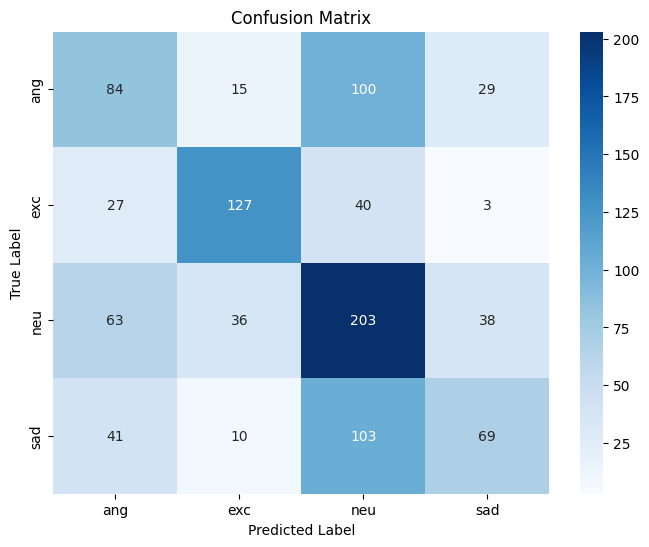

In [56]:
cm = evaluate_model(model, test_loader, device)

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import BertModel, BertConfig

class SpeechModel(nn.Module):
    def __init__(self):
        super(SpeechModel, self).__init__()
        config = BertConfig(
            hidden_size=128,
            num_hidden_layers=4,
            num_attention_heads=4,
            intermediate_size=256,
            max_position_embeddings=150,  # > 100
            vocab_size=1000  # 占位，无用
        )
        self.encoder = BertModel(config)
        self.input_proj = nn.Linear(34, 128)
        self.fc = nn.Linear(128, 256)

    def forward(self, x):  # [batch, 100, 34]
        x = self.input_proj(x)  # [batch, 100, 128]
        attention_mask = torch.ones(x.size()[:2], dtype=torch.long, device=x.device)  # 全部有效
        outputs = self.encoder(inputs_embeds=x, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)  # [batch, 128]
        x = self.fc(pooled)  # [batch, 256]
        return x


class MoCapModel(nn.Module):
    def __init__(self):
        super(MoCapModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 6, 256)

    def forward(self, x):
        x = F.relu(self.dropout(self.conv1(x)))
        x = F.relu(self.dropout(self.conv2(x)))
        x = F.relu(self.dropout(self.conv3(x)))
        x = F.relu(self.dropout(self.conv4(x)))
        x = F.relu(self.dropout(self.conv5(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.speech_model = SpeechModel()
        self.mocap_model = MoCapModel()
        self.fc1 = nn.Linear(256 + 256, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 classes for output

    def forward(self, x_speech, x_mocap):
        out_speech = self.speech_model(x_speech)
        out_mocap = self.mocap_model(x_mocap)
        combined = torch.cat((out_speech, out_mocap), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)  # Logits output (no softmax)
        return x

model = CombinedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for speech, mocap, labels in train_loader:
        speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
        
        labels = torch.argmax(labels, dim=1) 

        optimizer.zero_grad()
        outputs = model(speech, mocap)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for speech, mocap, labels in test_loader:
            speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)

            outputs = model(speech, mocap)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")



[Epoch 1/10] Train Loss: 1.3571, Train Accuracy: 35.39%
Test Accuracy: 35.43%
[Epoch 2/10] Train Loss: 1.3460, Train Accuracy: 35.79%
Test Accuracy: 35.83%
[Epoch 3/10] Train Loss: 1.3353, Train Accuracy: 36.65%
Test Accuracy: 36.74%
[Epoch 4/10] Train Loss: 1.2820, Train Accuracy: 40.98%
Test Accuracy: 43.32%
[Epoch 5/10] Train Loss: 1.1724, Train Accuracy: 46.05%
Test Accuracy: 53.64%
[Epoch 6/10] Train Loss: 1.0322, Train Accuracy: 54.74%
Test Accuracy: 58.50%
[Epoch 7/10] Train Loss: 1.0112, Train Accuracy: 55.78%
Test Accuracy: 56.98%
[Epoch 8/10] Train Loss: 0.9928, Train Accuracy: 57.17%
Test Accuracy: 58.70%
[Epoch 9/10] Train Loss: 0.9927, Train Accuracy: 56.23%
Test Accuracy: 59.82%
[Epoch 10/10] Train Loss: 0.9746, Train Accuracy: 57.22%
Test Accuracy: 57.89%


Classification Report:

              precision    recall  f1-score   support

         ang     0.5056    0.7982    0.6190       228
         exc     0.7445    0.5178    0.6108       197
         neu     0.5559    0.5118    0.5329       340
         sad     0.6404    0.5112    0.5686       223

    accuracy                         0.5789       988
   macro avg     0.6116    0.5847    0.5828       988
weighted avg     0.6010    0.5789    0.5764       988



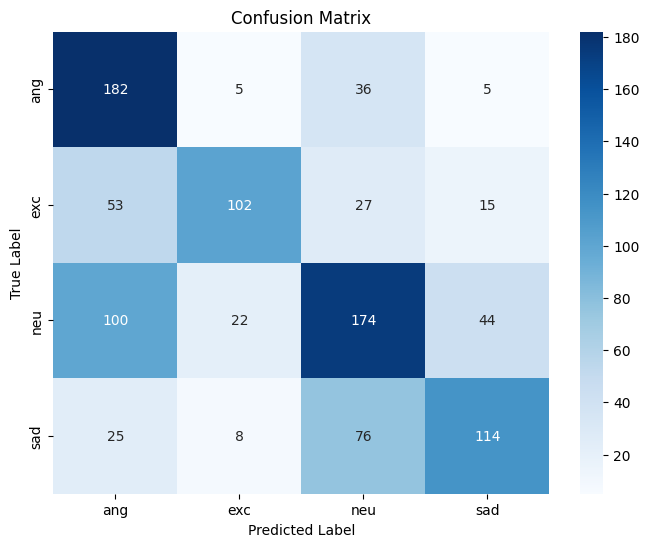

In [60]:
cm = evaluate_model(model, test_loader, device)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import BertModel, BertConfig

from transformers import T5EncoderModel, T5Config

class SpeechModel(nn.Module):
    def __init__(self):
        super(SpeechModel, self).__init__()
        config = T5Config(
            d_model=128,
            d_kv=32,
            d_ff=256,
            num_layers=4,
            num_heads=4,
            relative_attention_num_buckets=8,
            feed_forward_proj="relu",
            dropout_rate=0.1,
        )
        self.encoder = T5EncoderModel(config)
        self.input_proj = nn.Linear(34, 128)  # Project features to T5 embedding dim
        self.fc = nn.Linear(128, 256)  # Final output for CombinedModel

    def forward(self, x):  # [batch, 100, 34]
        x = self.input_proj(x)  # [batch, 100, 128]
        attention_mask = torch.ones(x.size()[:2], dtype=torch.long, device=x.device)
        encoder_outputs = self.encoder(inputs_embeds=x, attention_mask=attention_mask)
        pooled = encoder_outputs.last_hidden_state.mean(dim=1)  # [batch, 128]
        x = self.fc(pooled)  # [batch, 256]
        return x



class MoCapModel(nn.Module):
    def __init__(self):
        super(MoCapModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 6, 256)

    def forward(self, x):
        x = F.relu(self.dropout(self.conv1(x)))
        x = F.relu(self.dropout(self.conv2(x)))
        x = F.relu(self.dropout(self.conv3(x)))
        x = F.relu(self.dropout(self.conv4(x)))
        x = F.relu(self.dropout(self.conv5(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.speech_model = SpeechModel()
        self.mocap_model = MoCapModel()
        self.fc1 = nn.Linear(256 + 256, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 classes for output

    def forward(self, x_speech, x_mocap):
        out_speech = self.speech_model(x_speech)
        out_mocap = self.mocap_model(x_mocap)
        combined = torch.cat((out_speech, out_mocap), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)  # Logits output (no softmax)
        return x

model = CombinedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for speech, mocap, labels in train_loader:
        speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
        
        labels = torch.argmax(labels, dim=1) 

        optimizer.zero_grad()
        outputs = model(speech, mocap)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for speech, mocap, labels in test_loader:
            speech, mocap, labels = speech.to(device), mocap.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)

            outputs = model(speech, mocap)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")



[Epoch 1/10] Train Loss: 1.3523, Train Accuracy: 35.71%
Test Accuracy: 36.23%
[Epoch 2/10] Train Loss: 1.3043, Train Accuracy: 38.83%
Test Accuracy: 42.51%
[Epoch 3/10] Train Loss: 1.2033, Train Accuracy: 43.57%
Test Accuracy: 45.55%
[Epoch 4/10] Train Loss: 1.1465, Train Accuracy: 46.76%
Test Accuracy: 45.55%
[Epoch 5/10] Train Loss: 1.1387, Train Accuracy: 48.40%
Test Accuracy: 48.79%
[Epoch 6/10] Train Loss: 1.0540, Train Accuracy: 53.22%
Test Accuracy: 56.48%
[Epoch 7/10] Train Loss: 1.0193, Train Accuracy: 55.04%
Test Accuracy: 60.53%
[Epoch 8/10] Train Loss: 1.0034, Train Accuracy: 56.03%
Test Accuracy: 57.59%
[Epoch 9/10] Train Loss: 0.9852, Train Accuracy: 57.29%
Test Accuracy: 60.53%
[Epoch 10/10] Train Loss: 0.9737, Train Accuracy: 57.22%
Test Accuracy: 60.73%


Classification Report:

              precision    recall  f1-score   support

         ang     0.6239    0.5965    0.6099       228
         exc     0.6482    0.6548    0.6515       197
         neu     0.5527    0.5706    0.5615       340
         sad     0.6409    0.6323    0.6366       223

    accuracy                         0.6073       988
   macro avg     0.6164    0.6135    0.6149       988
weighted avg     0.6081    0.6073    0.6076       988



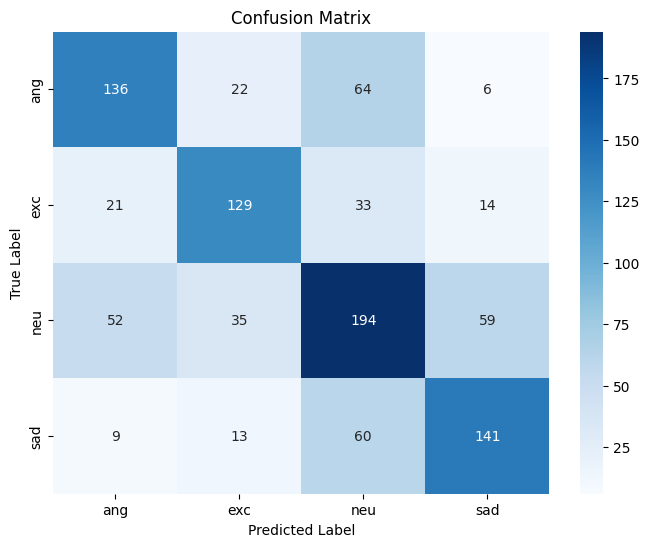

In [62]:
cm = evaluate_model(model, test_loader, device)